In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


# Loading Data

In [21]:
df = pd.read_csv("/Users/gabriel/Desktop/marcy/CID_Food_Access/data/raw/Individual_Census.csv")
df.head()

,Report Date,Borough,Community Districts,Census Type,Adult Family Commercial Hotel,Adult Family Shelter,Adult Shelter,Adult Shelter Commercial Hotel,Family Cluster,Family with Children Commercial Hotel,Family with Children Shelter
0,01/31/2026,Queens,8.0,Individuals,0.0,0.0,172,0,0,158,297
1,01/31/2026,Queens,7.0,Individuals,0.0,0.0,322,0,0,76,0
2,01/31/2026,Queens,6.0,Individuals,0.0,0.0,100,0,0,0,244
3,01/31/2026,Bronx,1.0,Individuals,0.0,0.0,660,159,0,223,"1,463"
4,01/31/2026,Bronx,10.0,Individuals,0.0,0.0,0,0,0,0,529


In [22]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5204 entries, 0 to 5203
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Report Date                            5204 non-null   object 
 1   Borough                                5204 non-null   object 
 2   Community Districts                    5179 non-null   float64
 3   Census Type                            5204 non-null   object 
 4   Adult Family Commercial Hotel          232 non-null    float64
 5   Adult Family Shelter                   1258 non-null   float64
 6   Adult Shelter                          3245 non-null   object 
 7   Adult Shelter Commercial Hotel         2028 non-null   object 
 8   Family Cluster                         457 non-null    object 
 9   Family with Children Commercial Hotel  2194 non-null   object 
 10  Family with Children Shelter           3685 non-null   object 
dtypes: f

,Community Districts,Adult Family Commercial Hotel,Adult Family Shelter
count,5179.000000,232.000000,1258.00000
mean,7.423441,136.370690,207.63434
std,4.486329,129.429586,107.17707
min,1.000000,0.000000,0.00000
25%,3.000000,37.750000,132.00000
50%,7.000000,106.000000,194.00000
75%,11.000000,163.250000,292.00000
max,18.000000,546.000000,620.00000


# Basic Cleaning

In [23]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df.isna().sum()

report_date                                 0
borough                                     0
community_districts                        25
census_type                                 0
adult_family_commercial_hotel            4972
adult_family_shelter                     3946
adult_shelter                            1959
adult_shelter_commercial_hotel           3176
family_cluster                           4747
family_with_children_commercial_hotel    3010
family_with_children_shelter             1519
dtype: int64

In [24]:
# Dropping rows with missing key geography or counts
df = df.dropna(subset=["borough", "community_districts"])

In [25]:
shelter_cols = [
    "adult_family_commercial_hotel",
    "adult_family_shelter",
    "adult_shelter",
    "adult_shelter_commercial_hotel",
    "family_cluster",
    "family_with_children_commercial_hotel",
    "family_with_children_shelter"
]

In [27]:
for col in shelter_cols:
    df[col] = (
    df[col]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.strip()
    .replace({"": np.nan})
)


df[col] = pd.to_numeric(df[col], errors="coerce")

In [28]:
df[shelter_cols].dtypes

adult_family_commercial_hotel             object
adult_family_shelter                      object
adult_shelter                             object
adult_shelter_commercial_hotel            object
family_cluster                            object
family_with_children_commercial_hotel     object
family_with_children_shelter             float64
dtype: object

In [29]:
long_df = df.melt(
id_vars=["report_date", "borough", "community_districts", "census_type"],
value_vars=shelter_cols,
var_name="facility_type",
value_name="count",
)


long_df["count"] = pd.to_numeric(long_df["count"], errors="coerce")

# Visual EDA

In [40]:
sns.set_theme(style="whitegrid", context="talk")
order_fac = long_df.groupby("facility_type")["count"].median().sort_values().index

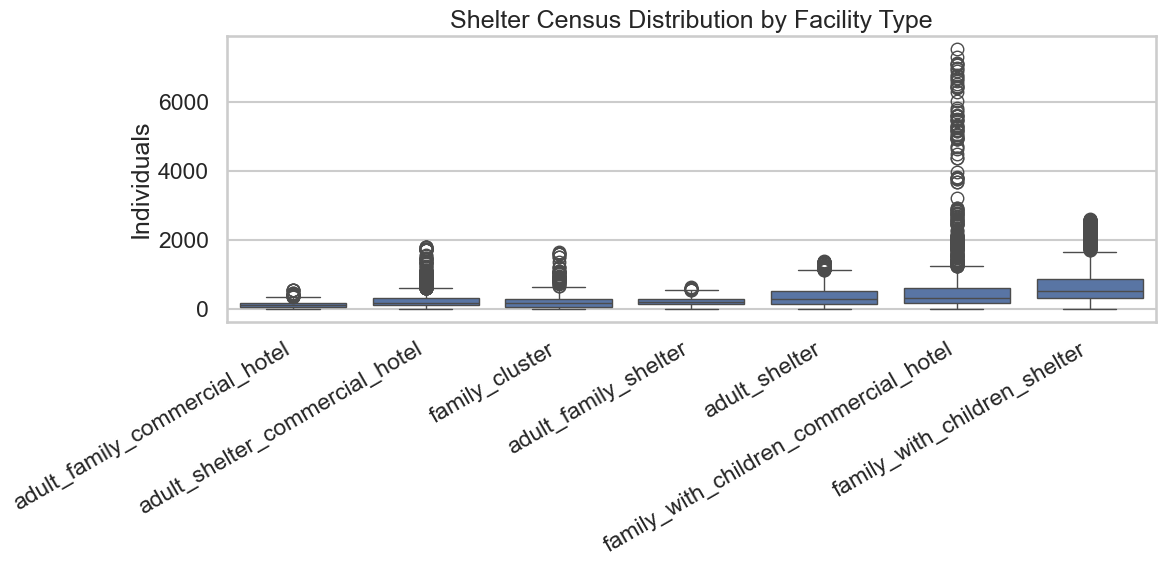

In [47]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=long_df, x="facility_type", y="count", order=order_fac)
plt.xticks(rotation=30, ha="right")
plt.title("Shelter Census Distribution by Facility Type")
plt.xlabel("")
plt.ylabel("Individuals")
plt.tight_layout()
plt.show()

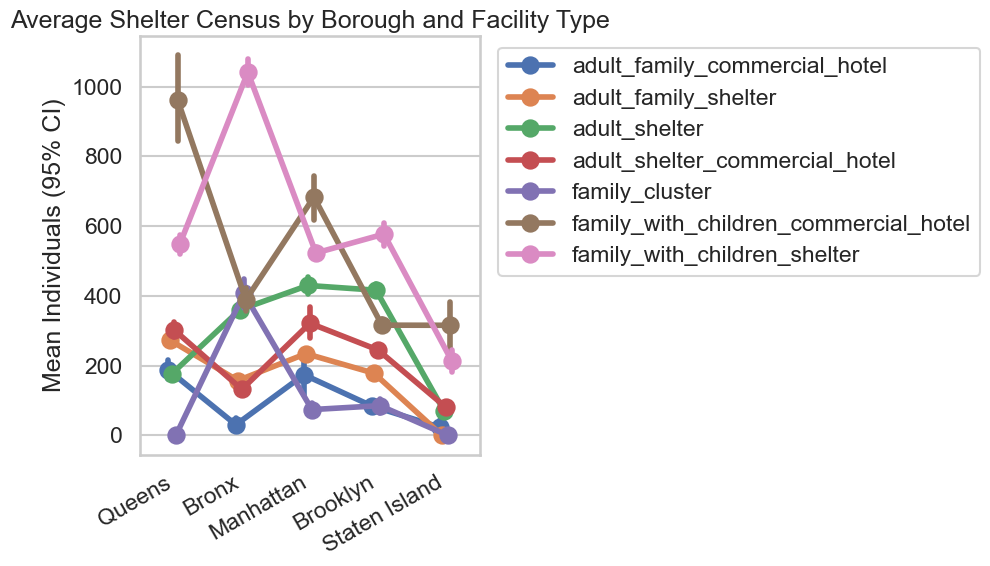

In [48]:
plt.figure(figsize=(10, 6))
sns.pointplot(
data=long_df,
x="borough",
y="count",
hue="facility_type",
errorbar=("ci", 95),
dodge=True,
)


plt.xticks(rotation=30, ha="right")
plt.title("Average Shelter Census by Borough and Facility Type")
plt.xlabel("")
plt.ylabel("Mean Individuals (95% CI)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [49]:
long_df["report_date"] = pd.to_datetime(long_df["report_date"], errors="coerce")

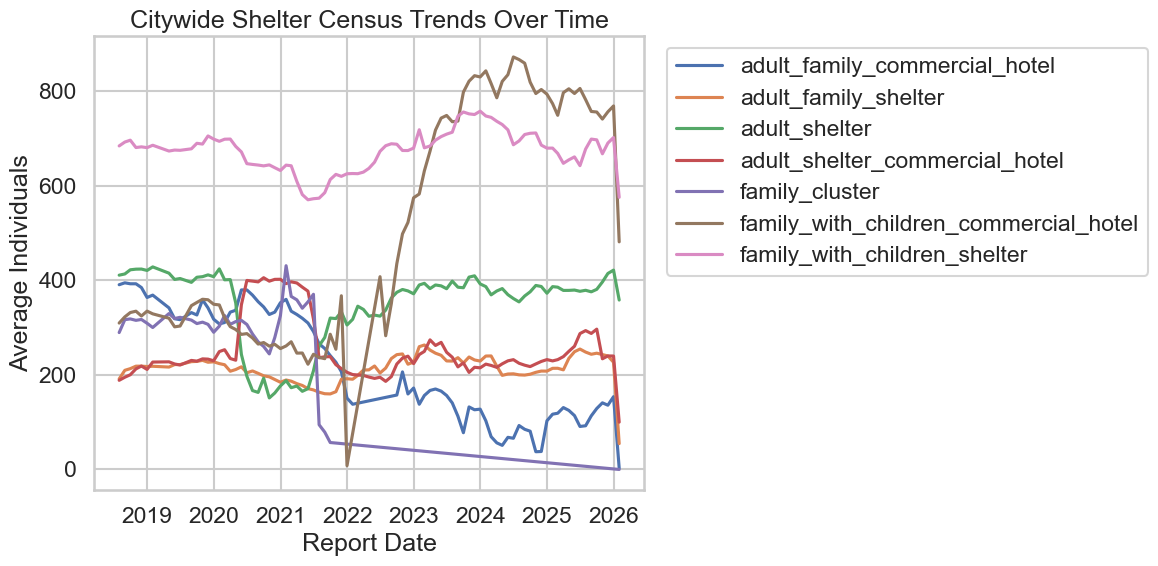

In [50]:
city_ts = (
long_df.groupby(["report_date", "facility_type"])["count"]
.mean()
.reset_index()
)


plt.figure(figsize=(12, 6))
sns.lineplot(data=city_ts, x="report_date", y="count", hue="facility_type")
plt.title("Citywide Shelter Census Trends Over Time")
plt.xlabel("Report Date")
plt.ylabel("Average Individuals")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

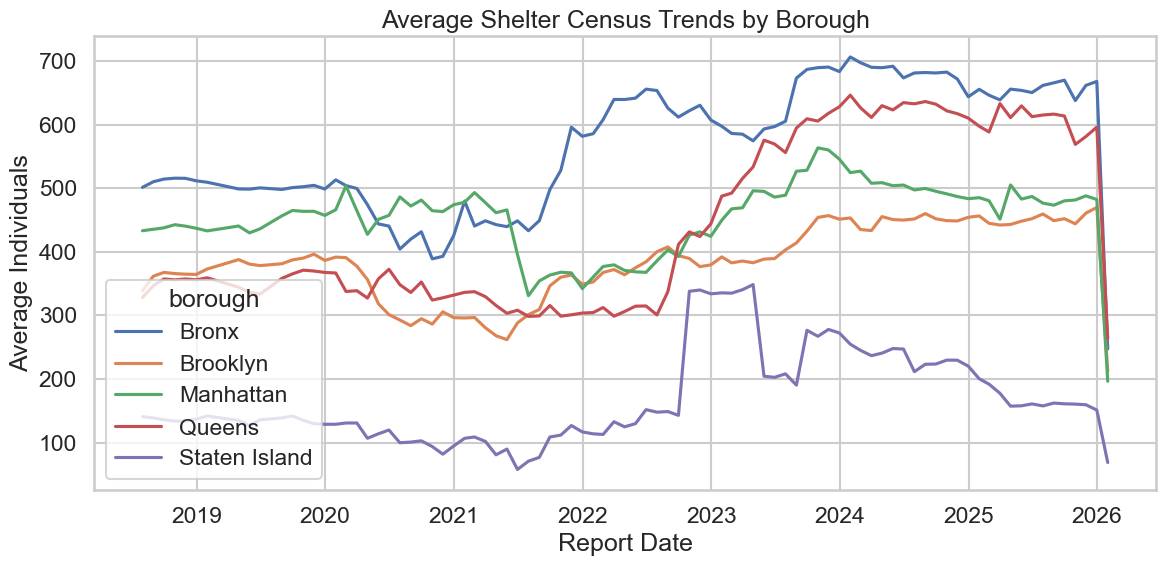

In [51]:
borough_ts = (
long_df.groupby(["report_date", "borough"])["count"]
.mean()
.reset_index()
)


plt.figure(figsize=(12, 6))
sns.lineplot(data=borough_ts, x="report_date", y="count", hue="borough")
plt.title("Average Shelter Census Trends by Borough")
plt.xlabel("Report Date")
plt.ylabel("Average Individuals")
plt.tight_layout()
plt.show()

# Statistical Testing

In [53]:
anova_results = {}
models = {}


for facility in long_df["facility_type"].dropna().unique():
    subset = long_df[long_df["facility_type"] == facility].dropna()


if subset["borough"].nunique() > 1:
    model = ols("count ~ C(borough)", data=subset).fit()
    anova_results[facility] = sm.stats.anova_lm(model, typ=2)
    models[facility] = model


anova_results

{'family_with_children_shelter':                   sum_sq      df           F         PR(>F)
 C(borough)  1.885685e+08     4.0  184.846975  1.525519e-144
 Residual    9.385222e+08  3680.0         NaN            NaN}

# Assunption Checks

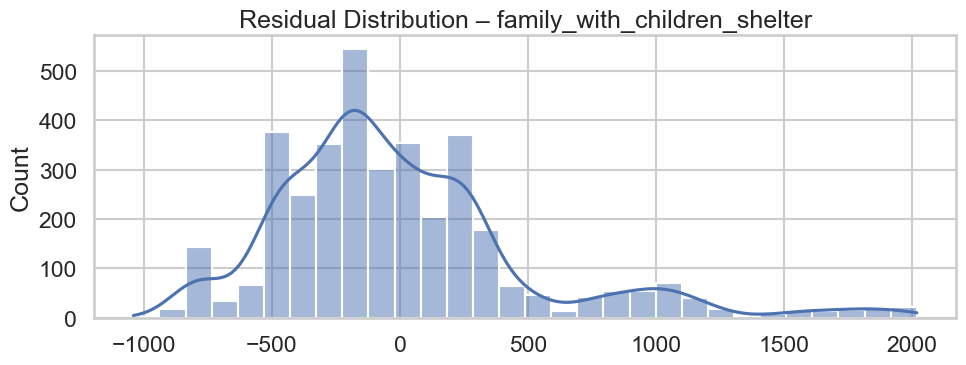

/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


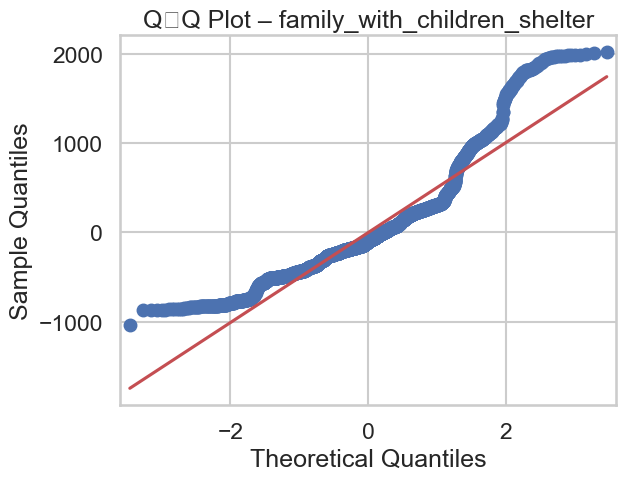

In [54]:
example_facility = list(models.keys())[0]
residuals = models[example_facility].resid


plt.figure(figsize=(10, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title(f"Residual Distribution – {example_facility}")
plt.tight_layout()
plt.show()


sm.qqplot(residuals, line="s")
plt.title(f"Q‑Q Plot – {example_facility}")
plt.show()

## Key Findings Framework

- Shelter census counts vary across facility types, boroughs, and time, indicating uneven geographic and temporal concentration.

- Because facility categories may overlap, totals across columns could misrepresent the number of individuals in shelters.

- The analysis therefore evaluates patterns within facility types and time trends, rather than constructing a combined population measure.

- ANOVA results indicate whether mean census counts differ by borough for specific shelter facility categories.

## Overall Interpretation

These results provide contextual geographic and temporal evidence of where shelter populations are concentrated. Findings should be interpreted as descriptive structural patterns, not precise counts of individuals and not child‑level conclusions.

## Next Analytical Step (Possible Project Alignment)

The strongest extension is to merge CDTA2020 → NTA geography and compare: Shelter population concentration vs. emergency food resource distribution,
which directly supports the project’s core research question about food insecurity and shelter context in NYC neighborhoods.